In [2]:
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.metrics import accuracy_score

In [4]:

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
df=pd.read_excel('Z-Alizadeh sani dataset.xlsx')
df.head()

Age  Weight  Length    Sex        BMI  DM  HTN  Current Smoker  EX-Smoker  \
0   53      90     175   Male  29.387755   0    1               1          0   
1   67      70     157  Fmale  28.398718   0    1               0          0   
2   54      54     164   Male  20.077335   0    0               1          0   
3   66      67     158  Fmale  26.838648   0    1               0          0   
4   50      87     153  Fmale  37.165193   0    1               0          0   

   FH   ...      K   Na    WBC Lymph Neut  PLT EF-TTE  Region RWMA     VHD  \
0   0   ...    4.7  141   5700    39   52  261     50            0       N   
1   0   ...    4.7  156   7700    38   55  165     40            4       N   
2   0   ...    4.7  139   7400    38   60  230     40            2    mild   
3   0   ...    4.4  142  13000    18   72  742     55            0  Severe   
4   0   ...    4.0  140   9200    55   39  274     50            0  Severe   

     Cath  
0     Cad  
1     Cad  
2     Cad  
3  Normal  
4  Normal  

[5 rows x 56 columns]

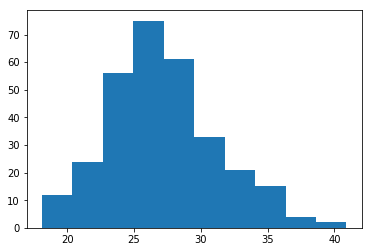

In [6]:

def extract_col(df,col_name):
    return list(df[col_name])

col = extract_col(df,'BMI') 
plt.hist(col)


plt.show()

### Taking all categorical features that have only 2 levels and label encoding them to get binary features

In [2]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols=list(set(cols) - set(num_cols))
##BBB, VHD have multiple levels rest are binary
###Cath is predictor var
cat_cols.remove('VHD')
cat_cols.remove('Cath')
cat_cols.remove('BBB')
cat_cols

['DLP',
 'CRF',
 'Obesity',
 'Poor R Progression',
 'Exertional CP',
 'Airway disease',
 'LowTH Ang',
 'Sex',
 'Nonanginal',
 'Diastolic Murmur',
 'Dyspnea',
 'Thyroid Disease',
 'Lung rales',
 'CVA',
 'CHF',
 'Weak Peripheral Pulse',
 'Atypical',
 'LVH',
 'Systolic Murmur']

In [3]:
### Fitting our Encoder

In [4]:
df[cat_cols]=df[cat_cols].apply(LabelEncoder().fit_transform)

#### One hot encoding our multiple level features: 'VHD' and 'BBB'

In [5]:
from sklearn.feature_extraction import DictVectorizer
def encode_onehot(df, cols):
    vec = DictVectorizer()
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict('records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df
X = encode_onehot(df, cols=['BBB'])
X1 =encode_onehot(X, cols=['VHD'])
X1.columns

Index(['Age', 'Weight', 'Length', 'Sex', 'BMI', 'DM', 'HTN', 'Current Smoker',
       'EX-Smoker', 'FH', 'Obesity', 'CRF', 'CVA', 'Airway disease',
       'Thyroid Disease', 'CHF', 'DLP', 'BP', 'PR', 'Edema',
       'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur',
       'Diastolic Murmur', 'Typical Chest Pain', 'Dyspnea', 'Function Class',
       'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 'Q Wave',
       'St Elevation', 'St Depression', 'Tinversion', 'LVH',
       'Poor R Progression', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'BUN', 'ESR',
       'HB', 'K', 'Na', 'WBC', 'Lymph', 'Neut', 'PLT', 'EF-TTE', 'Region RWMA',
       'Cath', 'BBB=LBBB', 'BBB=N', 'BBB=RBBB', 'VHD=Moderate', 'VHD=N',
       'VHD=Severe', 'VHD=mild'],
      dtype='object')

### Getting our pred variable and removing from orignal df

In [6]:
y=df["Cath"].map({'Cad':0,'Normal':1})
X1.drop('Cath',1,inplace=True)

### Splitting into train and test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=3)

### Hypertuning our featureset using grid search to get best possible params

In [21]:
from sklearn.model_selection import GridSearchCV
Depth=[2,3,4,5]
Trees=[200,500,700]
tuned_parameters = [{'n_estimators': Trees,'max_depth':Depth}]              
RFM = RandomForestClassifier()
clf = GridSearchCV(RFM, tuned_parameters, cv=5,scoring='accuracy')
clf.fit(X1,y)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:

{'max_depth': 5, 'n_estimators': 200}


C:\Users\HADY  IIT\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


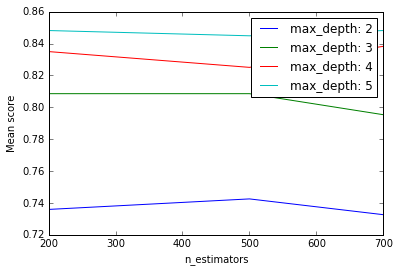

In [22]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(Depth), len(Trees))
for ind, i in enumerate(Depth):
    plt.plot(Trees, scores[ind], label='max_depth: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean score')
plt.show()

### This is for plotting our feature importances with their standard deviations

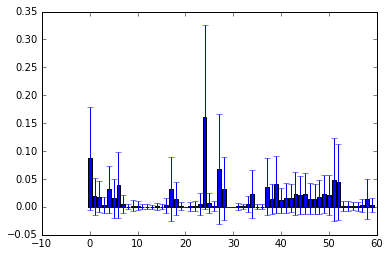

In [23]:
clfs = RandomForestClassifier(n_estimators= clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'])
clfs.fit(X1, y.ravel())

importance = clfs.feature_importances_
importance = pd.DataFrame(importance, index=X1.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clfs.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

In [24]:
importance

Importance       Std
Age                      0.086779  0.092552
Weight                   0.018672  0.032956
Length                   0.018183  0.027928
Sex                      0.003414  0.013603
BMI                      0.031609  0.042215
DM                       0.015427  0.034442
HTN                      0.038735  0.059296
Current Smoker           0.005287  0.015965
EX-Smoker                0.000587  0.004463
FH                       0.002472  0.010216
Obesity                  0.002333  0.008439
CRF                      0.000534  0.004805
CVA                      0.000469  0.004108
Airway disease           0.000474  0.003385
Thyroid Disease          0.001086  0.006045
CHF                      0.000407  0.004046
DLP                      0.003296  0.013382
BP                       0.031988  0.056958
PR                       0.014277  0.029568
Edema                    0.001758  0.007496
Weak Peripheral Pulse    0.000000  0.000000
Lung rales               0.001332  0.007931
Systolic Murmur          0.001853  0.008916
Diastolic Murmur         0.004950  0.020264
Typical Chest Pain       0.161378  0.165277
Dyspnea                  0.006237  0.017810
Function Class           0.001798  0.008412
Atypical                 0.067681  0.098911
Nonanginal               0.032299  0.056285
Exertional CP            0.000000  0.000000
LowTH Ang                0.000000  0.000000
Q Wave                   0.000976  0.005923
St Elevation             0.000906  0.004613
St Depression            0.005336  0.014798
Tinversion               0.022593  0.042821
LVH                      0.000687  0.004452
Poor R Progression       0.000546  0.004018
FBS                      0.036382  0.051744
CR                       0.014378  0.027248
TG                       0.040267  0.051599
LDL                      0.011746  0.022602
HDL                      0.015883  0.027084
BUN                      0.015708  0.025022
ESR                      0.023733  0.038713
HB                       0.021479  0.033380
K                        0.023375  0.036937
Na                       0.014249  0.027810
WBC                      0.014354  0.026839
Lymph                    0.018147  0.030376
Neut                     0.022351  0.034163
PLT                      0.021242  0.035043
EF-TTE                   0.049034  0.074234
Region RWMA              0.044669  0.068886
BBB=LBBB                 0.001229  0.008498
BBB=N                    0.002322  0.008860
BBB=RBBB                 0.000986  0.006953
VHD=Moderate             0.001554  0.008084
VHD=N                    0.002828  0.011718
VHD=Severe               0.014135  0.036448
VHD=mild                 0.003587  0.013188

### Final checking of our model's accuracy on test set

In [25]:
clf = RandomForestClassifier(n_estimators= clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'])
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print()
print()
print('The accuracy score on test by Random Forest:{}'.format(accuracy_score(y_test,y_pred)))

0.885245901639


The accuracy score on test by Random Forest:0.8852459016393442
